### A detailed notebook to perform 21cm signal extraction from a simulated mock observation. 

Importing dependencies

In [31]:
import sys; sys.path.insert(1, './../')
from src.readset import Modset, Inputs
from src.noise import Noise
from src.basis import Basis
from src.visuals import Visual
from src.infocrit import InfoCrit
from src.extractor import Extractor
from settings import Settings

%matplotlib inline

---
Pipeline settings

In [32]:
set = Settings()
set.ANT = ["dipole", "logspiral", "sinuous"]
set.ANT = ["dipole"]
set.LST = 2
set.PATH21TS = "../data/TS21/lfcal_training_set_8-2020.hdf5"
set.PATHFGTS = "../data/TSFG/Nreg_1/"
set.SAVE = False
set.printSettings()

if set.VISUALS:
    vis = Visual(nu=set.NU, nLST=set.LST, ant=set.ANT, save=set.SAVE)


------------------ Settings for the pipeline ------------------

Frequencies: Between (50 - 200) MHz with step size of 1 MHz.
21 TS: ../data/TS21/lfcal_training_set_8-2020.hdf5
FG TS: ../data/TSFG/Nreg_1/
Number of time bins: 2
Start time of each time bin: 00:00:00 03:00:00
Each value is this list is integrated for 6 bins
Antenna design: ['dipole']
Integration time for each time bin: 12.0 h
Total number of foreground modes: 80
Total number of 21cm modes: 80
Information Criterion: DIC
Filename to store the info criteria: ./DIC_search.txt
Visualization: True
Save figures: False 



---
Modeling sets: 21cm and beam-weighted foregrounds

Modelling set: Reading 21 modelling set...Done!
Modelling set: Reading FG modelling set...Done!


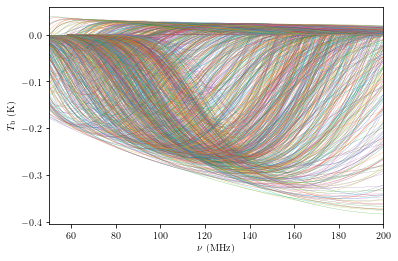

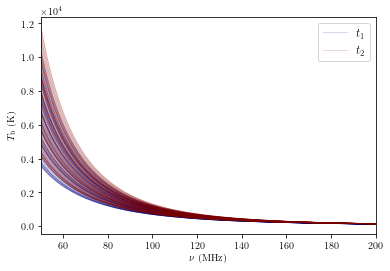

In [33]:
models = Modset(nu=set.NU, nLST=set.LST, ant=set.ANT)
m21 = models.get21modset(file=set.PATH21TS, nuMin=50, nuMax=200)
mFg = models.getcFgModsetGivenTimeAnt(path=set.PATHFGTS, date="2019-10-01", numReg=1, fgModel="gsm",
                                      dateTimeList=set.timeList, intBins=set.intBins, antenna=set.ANT)

vis.plotModset(set=m21, opt='21', n_curves=1000)
vis.plotModset(set=mFg, opt='FG', n_curves=100)

---
Mock Observation

In [34]:
''' Generating inputs from the modelling sets '''
inputs = Inputs(nu=set.NU, nLST=set.LST, ant=set.ANT)
y21, y_x21 = inputs.getExp21(modset=m21, ind=467)
yFg = inputs.getFg(modset=mFg, ind=0)

In [35]:
''' noise and its covariance '''
noise = Noise(nu=set.NU, nLST=set.LST, ant=set.ANT, power=y_x21 + yFg,
              deltaNu=set.dNU, deltaT=set.dT)
realz = noise.noiseRealz()
cmat = noise.covmat()
cmatInv = noise.covmatInv()

In [36]:
''' noise covariance weighted modelling sets '''
wgt_m21 = noise.wgtTs(modset=m21, opt='21')
wgt_mFg = noise.wgtTs(modset=mFg, opt='FG')

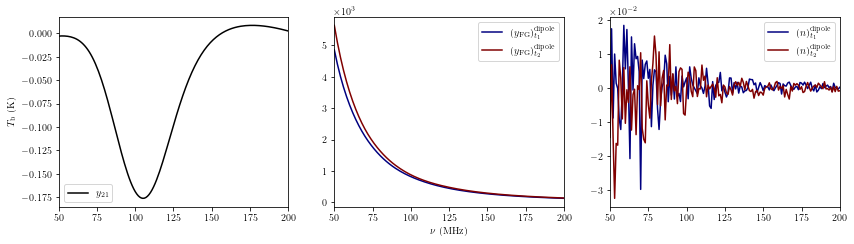

In [37]:
''' mock observation '''
y = y_x21 + yFg + realz

vis.plotMockObs(y21=y21, yFg=yFg, noise=realz)

---
Singular Value Decomposition to find optimal basis

Basis: Performing SVD of 21 modelling set...Done!
Basis: Performing SVD of FG modelling set...Done!


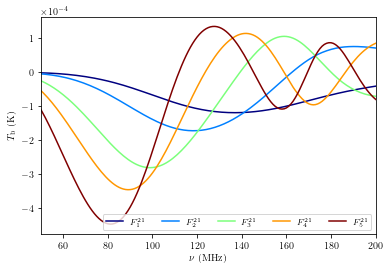

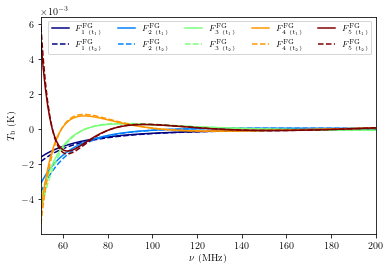

In [38]:
basis = Basis(nu=set.NU, nLST=set.LST, ant=set.ANT)
b21 = basis.wgtSVDbasis(modset=wgt_m21, covmat=cmat, opt='21')
bFg = basis.wgtSVDbasis(modset=wgt_mFg, covmat=cmat, opt='FG')

vis.plotBasis(basis=b21, opt='21')
vis.plotBasis(basis=bFg, opt='FG')

---
Minimization of Information Criterion

Info Criterion: Calculating info criterion over grid...Done!
Info Critetion: Searching for minima over the grid...Done!
Info Criterion: IC is minimzed for 4 FG and 11 signal modes.


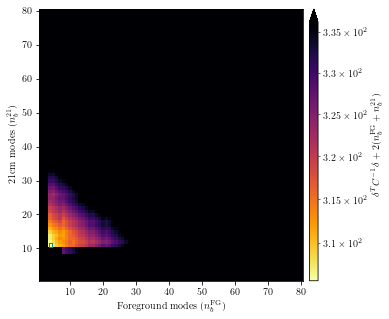

In [39]:
d = InfoCrit(nu=set.NU, nLST=set.LST, ant=set.ANT)
d.gridinfo(quantity=set.QUANTITY, modesFg=set.MODES_FG, modes21=set.MODES_21,
           wgtBasisFg=bFg, wgtBasis21=b21,
           covmatInv=cmatInv, mockObs=y, file=set.FNAME)
modesFg, modes21, dic = d.searchMinima(file=set.FNAME)

vis.plotInfoGrid(file=set.FNAME, modesFg=set.MODES_FG, modes21=set.MODES_21,
                 quantity=set.QUANTITY, minModesFg=modesFg, minModes21=modes21)

---
Extraction of 21cm signal!

Extractor: Extracting the 21cm signal...Done!
Extractor: RMS uncertainty = 11.32 mK
Extractor: Signal Bias Statistic = 1.69
Extractor: Normalized Deviance = 0.96



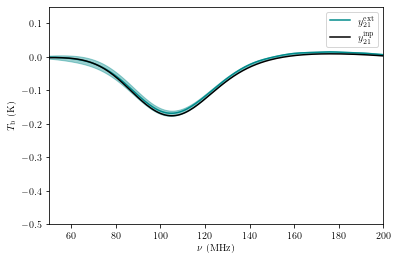

In [40]:
ext = Extractor(nu=set.NU, nLST=set.LST, ant=set.ANT)
extInfo = ext.extract(modesFg=modesFg, modes21=modes21,
                      wgtBasisFg=bFg, wgtBasis21=b21,
                      covmatInv=cmatInv, mockObs=y, y21=y21)

vis.plotExtSignal(y21=y21, recons21=extInfo[1], sigma21=extInfo[3])